In [1]:
%matplotlib inline
import numpy as np
import power_laws
import matplotlib.colors
import seaborn as sns
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
# Categories used to color enzymes by the physiology of their host organisms.
group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'Other Form I',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Gymnosperm': 'Other Form I',
                 'Basal angiosperm': 'Other Form I',
                 'Carnivorous plants': 'Other Form I',
                 'Bryophyte': 'Other Form I',
                 'CAM plants': 'Other Form I',
                 'Green algae': 'Other Form I',
                 'Diatoms': 'Other Form I',
                 'Chromophyte algae': 'Other Form I',
                 'Haptophyte algae': 'Other Form I',
                 'Rhodophyte algae': 'Other Form I',
                 'Macroalgae': 'Other Form I',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Other Form I',
                 'Betaproteobacteria': 'Other Form I',
                 'Gammaproteobacteria': 'Other Form I',
                }
color_mapping = {
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'C3 plants': 'dusty green',
    'Other plants': 'grey/green',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Diatoms': 'gunmetal',
    'Other algae': 'muddy brown',
    'Proteobacterial FI': 'dusty rose',
    'Other Form I': 'grey',
}
fancy_labels = {
    'C3-C4 plants': '$C_3$-$C_4$ plants',
    'C4 plants': '$C_4$ plants',
    'C3 plants': '$C_3$ plants',
}
label2color = dict((fancy_labels.get(k, k), sns.xkcd_rgb[color_mapping.get(k)])
                   for k in color_mapping.keys())

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

# Order of plotting sets order of legend.
plotting_order = ['C3 plants', 'C4 plants', 'Red algae', 'Cyanobacteria', 'Other Form I']
# These groups have enough data for histograms to be plotted.
hist_groups = ['C4 plants', 'C3 plants', 'Cyanobacteria', 'Red algae', ]

In [4]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

380 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


In [5]:
# kcat,C vs kcat,C/KC
vCs = np.log(merged_kin_df.vC)
kon_Cs = np.log(merged_kin_df.kon_C)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(vCs, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(vCs, kon_Cs))
print()

fIs = merged_kin_df[merged_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
kon_Cs = np.log(fIs.kon_C)

print('FI subset')
r, p = power_laws.log_pearsonr(vCs, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(vCs, kon_Cs))
print()

vCs = np.log(savir_df.vC)
kon_Cs = np.log(savir_df.kon_C)

print('Savir subset')
r, p = power_laws.log_pearsonr(vCs, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(vCs, kon_Cs))

Whole dataset correlation
Log-scale linear regression R = 0.27, P = 2.4e-05
Spearman rank correlation R = 0.12, P = 0.058

FI subset
Log-scale linear regression R = 0.12, P = 0.054
Spearman rank correlation R = 0.10, P = 0.11

Savir subset
Log-scale linear regression R = -0.72, P = 0.00046
Spearman rank correlation R = -0.57, P = 0.012


In [6]:
# Bootstrapped TLS fitting of kcat,C/KC vs kcat,C over the Form I data to calculate 95% CIs.
all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    all_FIs.vC, all_FIs.kon_C, fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]
pre_interval = np.percentile(pres, conf_range)
exp_interval = np.percentile(exps, conf_range)
rs_interval = np.percentile(rs, conf_range)

print(exp_interval)
print(pre_interval)
print(rs_interval)

[-49.56932898  55.28141088]
[2.13205063e-29 7.41494152e+24]
[-0.13398685  0.36658874]


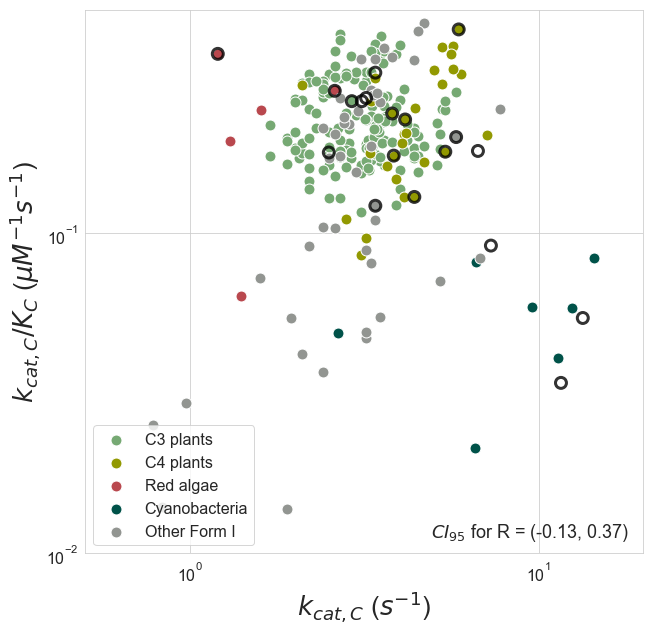

In [7]:
# Mechanistic proposal #1 from Savir - kcat,C vs. k_onC
# Coloring the points by host physiology for the groups that have enough data.
# Correlation is not strong over the FI subset - 95 CI for R includes 0.0.
figure = plt.figure(figsize=(10,10))
sns.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

for group in plotting_order:
    gdf = grouped_taxa.get_group(group)
    cname = color_mapping[group]
    c = sns.xkcd_rgb[cname]
    plt.scatter(gdf.vC, gdf.kon_C, c=c, s=120, label=group, edgecolors='w')

# Show savir data with an outline
plt.scatter(savir_df.vC, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=3, s=120, label=None, alpha=0.8, zorder=10)
plt.text(0.62, 0.03, '$CI_{95}$ for R = (%.2f, %.2f)' % (rs_interval[0], rs_interval[1]), 
         transform=figure.axes[0].transAxes, fontsize=18)
    
plt.legend(loc=3, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-2, 0.5)
plt.xlim(0.5, 20)

plt.savefig('fig6/fig6_konC_kcatC_FI_by_group.png', dpi=600)

plt.show()

In [8]:
# Print correlation coeffecients for the groups plotted. 
for i, (group, gdf) in enumerate(grouped_taxa):
    print(group)

    mask = gdf.kon_C.notnull() & gdf.vC.notnull()    
    log_konCs = np.log10(gdf[mask].kon_C)
    log_vCs = np.log10(gdf[mask].vC)
    print('R = %.2f, P = %.3g' % power_laws.log_pearsonr(log_konCs, log_vCs))


C3 plants
R = 0.01, P = 0.895
C4 plants
R = 0.48, P = 0.00785
Cyanobacteria
R = 0.26, P = 0.57
Other Form I
R = 0.62, P = 7.94e-06
Red algae
R = 0.18, P = 0.772
